In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import sklearn

The data can be obtained from https://www.kaggle.com/c/dont-call-me-turkey

In [2]:
!pwd 

/home/jovyan/DeepAndShallowMusic


In [3]:
!ls ./dont-call-me-turkey

model.h5  model.json  sample_submission.csv  test.json	train.json


Other possible pretrained embeddings: L3open, EdgeL3, YAMnet
Can try also traditional audio features from librosa: spectrogram, melspect, mfcc

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
#from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization,CuDNNLSTM, GRU, CuDNNGRU, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization,LSTM, GRU, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [7]:
train = pd.read_json('./dont-call-me-turkey/train.json')
display(train.shape)

(1195, 5)

In [8]:
type(train)

pandas.core.frame.DataFrame

In [9]:
train.head()

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0


In [10]:
train_train, train_val = train_test_split(train, random_state = 42)
xtrain = [k for k in train_train['audio_embedding']]
ytrain = train_train['is_turkey'].values
xval = [k for k in train_val['audio_embedding']]
yval = train_val['is_turkey'].values

In [11]:
x_train = pad_sequences(xtrain)
x_val = pad_sequences(xval, maxlen=10)
y_train = np.asarray(ytrain)
y_val = np.asarray(yval)

In [12]:
mat = x_train[2]
type(x_train)
x_train[1].shape

(10, 128)

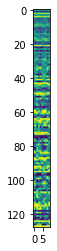

In [13]:
plt.figure(figsize=(2,4))
plt.imshow(mat.T)

In [16]:
model = Sequential()
model.add(BatchNormalization(momentum=0.98,input_shape=(10, 128)))
#model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model.add(Bidirectional(GRU(128, return_sequences = True)))
model.add(Bidirectional(GRU(64, return_sequences = False)))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = optimizers.Nadam(lr=0.001), metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 10, 128)           512       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 256)           198144    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               123648    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 322,433
Trainable params: 322,177
Non-trainable params: 256
_________________________________________________________________
None


In [17]:
Winit = model.get_weights()

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("./dont-call-me-turkey/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./dont-call-me-turkey/model.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
#fit on a portion of the training data, and validate on the rest
history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2)

Train on 896 samples, validate on 299 samples
Epoch 1/16
896/896 - 19s - loss: 0.6913 - accuracy: 0.5279 - val_loss: 0.6619 - val_accuracy: 0.5886
Epoch 2/16
896/896 - 2s - loss: 0.3687 - accuracy: 0.9096 - val_loss: 0.5319 - val_accuracy: 0.7726
Epoch 3/16
896/896 - 2s - loss: 0.2503 - accuracy: 0.9364 - val_loss: 0.4295 - val_accuracy: 0.8562
Epoch 4/16
896/896 - 2s - loss: 0.1860 - accuracy: 0.9420 - val_loss: 0.3563 - val_accuracy: 0.8930
Epoch 5/16
896/896 - 2s - loss: 0.1503 - accuracy: 0.9509 - val_loss: 0.3047 - val_accuracy: 0.8963
Epoch 6/16
896/896 - 2s - loss: 0.1305 - accuracy: 0.9554 - val_loss: 0.2656 - val_accuracy: 0.8997
Epoch 7/16
896/896 - 2s - loss: 0.1128 - accuracy: 0.9598 - val_loss: 0.2354 - val_accuracy: 0.9164
Epoch 8/16
896/896 - 2s - loss: 0.0998 - accuracy: 0.9676 - val_loss: 0.2243 - val_accuracy: 0.9030
Epoch 9/16
896/896 - 2s - loss: 0.0864 - accuracy: 0.9699 - val_loss: 0.2088 - val_accuracy: 0.9164
Epoch 10/16
896/896 - 2s - loss: 0.0789 - accuracy: 0

In [20]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
def plot_history(history):
    history_dict=history.history
    history_dict.keys()
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss_values, '-bo')
    # b+ is for "blue crosses"
    plt.plot(epochs, val_loss_values, '-b+')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.figure()
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, acc_values, '-bo')
    plt.plot(epochs, val_acc_values, '-b+')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

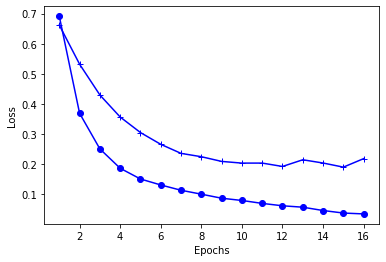

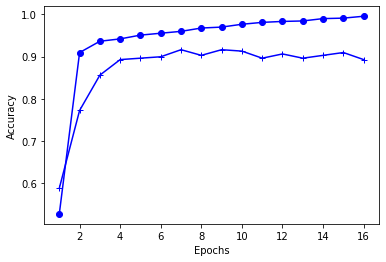

In [22]:
plot_history(history)

In [23]:
if 0:
    # load json and create model
    json_file = open('./dont-call-me-turkey/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("./dont-call-me-turkey/model.h5")
    print("Loaded model from disk")


### Early Stopping 

In [24]:
model.set_weights(Winit)

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3,  restore_best_weights=True)

history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2,callbacks=[early_stop])

ModuleNotFoundError: No module named 'keras'

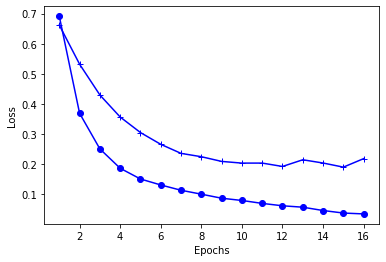

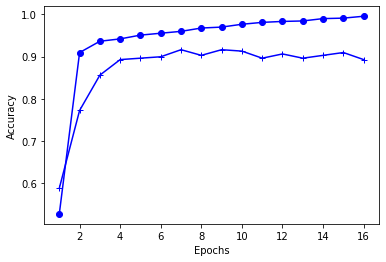

In [26]:
plot_history(history)

### Reduce Learning Rate

In [27]:
model.set_weights(Winit)

In [28]:
#early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3,  restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_lr=1e-8)

history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2,callbacks=[reduce_lr,early_stop])

NameError: name 'ReduceLROnPlateau' is not defined

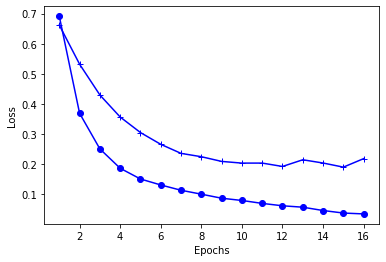

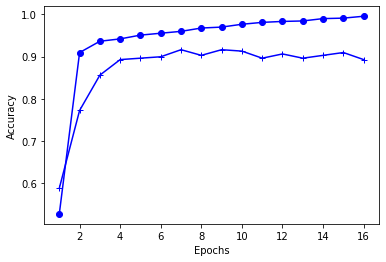

In [29]:
plot_history(history)

### ROC

In [30]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_val).ravel()
fpr, tpr, thresholds = roc_curve(yval, y_pred)

No handles with labels found to put in legend.


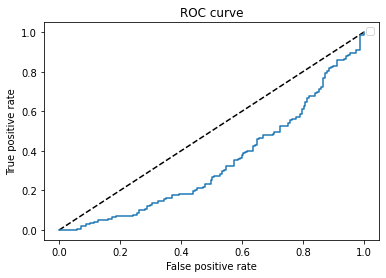

In [31]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr) # label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

For threshold 0.5880151 we get: tpr:  0.9084507042253521 fpr:  0.9745222929936306


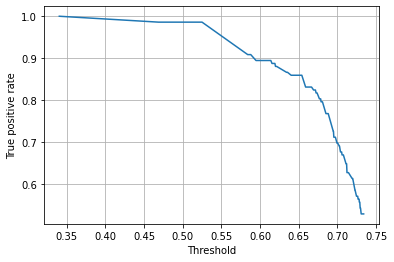

In [32]:
ind = [i for i, val in enumerate(tpr) if val>0.5] 
plt.plot(thresholds[ind],tpr[ind])
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('Threshold')
plt.ylabel('True positive rate')
plt.grid(b=True)

tpr_percentage = 0.90
indval = [i for i, val in enumerate(tpr) if val>=tpr_percentage]
print("For threshold", thresholds[indval[0]], "we get: tpr: ",tpr[indval[0]], "fpr: ", fpr[indval[0]])
threshold_percentage = thresholds[indval[0]]

In [33]:
#jdemonstrate the concept of tpr in terms of confusion matrix
from sklearn.metrics import confusion_matrix
yres = np.zeros(np.shape(yval))
yind = [i for i, res in enumerate(y_pred) if res >= threshold_percentage]
yres[yind] = 1
conf_mat = confusion_matrix(yval, yres)
tn, fp, fn, tp = conf_mat.ravel()
print("Confusion Matrix: \n ", conf_mat)
print("tpr from Confusion Matrix:", tp/(tp+fn))

Confusion Matrix: 
  [[  4 153]
 [ 13 129]]
tpr from Confusion Matrix: 0.9084507042253521


#### About differences between accuracy and ROC check 

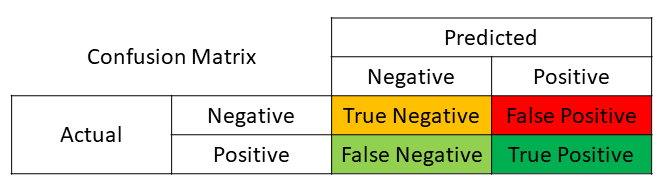


https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

### Classifier with alternative threshold

In [35]:
test = pd.read_json('./dont-call-me-turkey/test.json')
test.head()

,audio_embedding,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[177, 20, 226, 132, 198, 81, 111, 59, 132, 18...",pyKh38FXD3E,10,0
1,"[[169, 21, 204, 161, 195, 72, 60, 39, 152, 184...",THhP1idrWXA,40,30
2,"[[165, 13, 198, 141, 199, 81, 173, 54, 119, 11...",jsw3T6GY2Nw,40,30
3,"[[167, 18, 188, 159, 198, 63, 156, 36, 179, 22...",nFkXTMHcjMU,24,14
4,"[[178, 32, 181, 100, 198, 46, 82, 83, 136, 227...",Au8g9kAlrLQ,40,30


In [36]:
xtest = [k for k in test['audio_embedding']]
x_test = pad_sequences(xtest)

In [37]:
results = model.predict(np.array(x_test))
results[0]

array([0.599191], dtype=float32)

In [38]:
#yres = [1 for i, res in enumerate(results) if res > threshold_percentage]

for i, res in enumerate(results[0:10]):
    if res > threshold_percentage:
        print(i, ': Call me turkey')
    else:
        print(i, ': Don\'t call me turkey')
        

0 : Call me turkey
1 : Call me turkey
2 : Call me turkey
3 : Call me turkey
4 : Call me turkey
5 : Call me turkey
6 : Call me turkey
7 : Call me turkey
8 : Call me turkey
9 : Call me turkey
